# GBDT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum AUC value.</li>
    <li>Find the best hyper paramter using k-fold cross validation.</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>Plot the performance of model both on train data and cross validation data for each hyper parameter using seaborn heat maps with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>Once after we found the best hyper parameter, we need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
</li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [2]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
data = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')

In [4]:
import pickle
with open('/content/drive/MyDrive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [5]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [48]:
X=data.drop(['project_is_approved'],axis=1)
Y=data['project_is_approved']

In [49]:
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [50]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,stratify=Y,test_size=0.33)

In [51]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(73196, 8) (36052, 8) (73196,) (36052,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(min_df=10,max_features=5000)
vectorizer.fit(X_train['essay'])
X_train_essay=vectorizer.transform(X_train['essay'].values)
X_test_essay=vectorizer.transform(X_test['essay'].values)

print(X_train_essay.shape,X_test_essay.shape)

(73196, 5000) (36052, 5000)


In [11]:
dictionary=dict(zip(vectorizer.get_feature_names(),vectorizer.idf_))
tfidf_words=set(vectorizer.get_feature_names())

In [12]:
tfidf_w2v_train=[]
tfidf_w2v_test=[]

for sentence in tqdm(X_train['essay']):
  vector=np.zeros(300)
  tf_idf_weight=0

  for word in sentence.split():
    if (word in glove_words) and (word in tfidf_words):
      vec=model[word]
      tf_idf=dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector+=vec*tf_idf
      tf_idf_weight+=tf_idf
  if tf_idf_weight!=0:
    vector/=tf_idf_weight
  tfidf_w2v_train.append(vector)

for sentence in tqdm(X_test['essay']):
  vector=np.zeros(300)
  tf_idf_weight=0

  for word in sentence.split():
    if (word in glove_words) and (word in tfidf_words):
      vec=model[word]
      tf_idf=dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector+=vec*tf_idf
      tf_idf_weight+=tf_idf
  if tf_idf_weight!=0:
    vector/=tf_idf_weight
  tfidf_w2v_test.append(vector)

print(len(tfidf_w2v_train),len(tfidf_w2v_train[0]))
print(len(tfidf_w2v_test),len(tfidf_w2v_test[0]))

100%|██████████| 36052/36052 [01:20<00:00, 449.19it/s]

73196 300
36052 300


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h2>Encoding teacher_number_of_previously_posted_projects</h2>

In [98]:
from sklearn.preprocessing import Normalizer
normalizer=Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_proj=normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_proj=normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print(X_train_proj.shape)
print(X_test_proj.shape)

(1, 73196)
(1, 36052)


<h2>Encoding Price</h2>

In [99]:
from sklearn.preprocessing import Normalizer
normalizer=Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))
X_train_price=normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price=normalizer.transform(X_test['price'].values.reshape(1,-1))

print(X_train_proj.shape)
print(X_test_proj.shape)

(1, 73196)
(1, 36052)


In [100]:
X_train_positive=X_train.loc[Y_train==1]
X_train_negative=X_train.loc[Y_train==0]

print(X_train_positive.shape,X_train_negative.shape)

(62113, 18) (11083, 18)


<h2>Encoding school_state</h2>

In [101]:
school_state_positive={}
school_state_negative={}
school_state_total={}

for state in X_train_positive['school_state']:
  if state in school_state_positive:
    school_state_positive[state]+=1
  else:
    school_state_positive[state]=1

for state in X_train_negative['school_state']:
  if state in school_state_negative:
    school_state_negative[state]+=1
  else:
    school_state_negative[state]=1

for state in X_train['school_state']:
  if state in school_state_total:
    school_state_total[state]+=1
  else:
    school_state_total[state]=1
  if state not in school_state_positive:
    school_state_positive[state]=0
  if state not in school_state_negative:
    school_state_negative[state]=0

print(school_state_positive)
print(school_state_negative)
print(school_state_total)

prob_school_state_pos={}
prob_school_state_neg={}

for state in school_state_total.keys():
  prob_school_state_pos[state]=school_state_positive[state]/school_state_total[state]
  prob_school_state_neg[state]=school_state_negative[state]/school_state_total[state]

print(prob_school_state_pos)
print(prob_school_state_neg)

{'oh': 1460, 'ny': 4230, 'ca': 8877, 'sc': 2211, 'in': 1494, 'nm': 314, 'wi': 1035, 'or': 697, 'va': 1142, 'tn': 965, 'nc': 2897, 'wa': 1359, 'ct': 973, 'ut': 984, 'ma': 1384, 'az': 1206, 'fl': 3471, 'mi': 1810, 'la': 1309, 'il': 2491, 'ok': 1302, 'nj': 1266, 'co': 618, 'ms': 766, 'ky': 777, 'pa': 1745, 'hi': 302, 'ri': 157, 'ga': 2234, 'tx': 3998, 'mn': 700, 'de': 211, 'md': 842, 'mo': 1480, 'al': 1010, 'mt': 139, 'ks': 354, 'nv': 791, 'ar': 585, 'me': 274, 'dc': 295, 'sd': 178, 'wv': 284, 'ne': 173, 'id': 371, 'nd': 95, 'ak': 189, 'nh': 213, 'vt': 41, 'ia': 360, 'wy': 54}
{'pa': 295, 'sc': 362, 'mo': 253, 'or': 118, 'mi': 335, 'fl': 705, 'la': 265, 'nj': 233, 'mt': 36, 'ga': 433, 'va': 201, 'in': 270, 'ok': 273, 'nc': 487, 'az': 236, 'md': 157, 'nm': 63, 'tx': 931, 'mn': 118, 'al': 160, 'oh': 191, 'ms': 123, 'nv': 124, 'wa': 197, 'ny': 683, 'ct': 148, 'me': 50, 'ky': 112, 'ak': 45, 'ca': 1471, 'wy': 12, 'il': 437, 'sd': 34, 'wi': 186, 'tn': 172, 'id': 83, 'ma': 223, 'ut': 199, 'co': 

In [102]:
import warnings
warnings.filterwarnings("ignore")

school_state_1_train=[]
school_state_0_train=[]

for state in X_train['school_state']:
  school_state_1_train+=prob_school_state_pos[state],
  school_state_0_train+=prob_school_state_neg[state],

school_state_1_test=[]
school_state_0_test=[]

for state in X_test['school_state']:
  if state in prob_school_state_pos:
    school_state_1_test+=prob_school_state_pos[state],
  else:
    school_state_1_test+=0.5,
  if state in prob_school_state_neg:
    school_state_0_test+=prob_school_state_neg[state],
  else:
    school_state_0_test+=0.5,

X_train['school_state_1']=school_state_1_train
X_train['school_state_0']=school_state_0_train
X_test['school_state_1']=school_state_1_test
X_test['school_state_0']=school_state_0_test

In [103]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
102241,oh,ms,grades_3_5,6,literacy_language math_science,literature_writing mathematics,project based learning we technology world tes...,35.70,0.884313,0.115687,0.844534,0.155466,0.85413,0.14587,0.871690,0.128310,1.0,0.0
56703,ny,mr,grades_3_5,0,health_sports specialneeds,health_wellness specialneeds,i student frequently falls seat little girl cl...,282.97,0.860981,0.139019,0.840506,0.159494,0.85413,0.14587,0.876727,0.123273,1.0,0.0


In [104]:
X_test.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
74877,la,ms,grades_3_5,7,literacy_language specialneeds,literacy specialneeds,no matter age students love learn i teach amaz...,338.88,0.831639,0.168361,0.844534,0.155466,0.85413,0.14587,0.854428,0.145572,0.861282,0.138718
95629,ct,mrs,grades_3_5,6,literacy_language math_science,literature_writing mathematics,what could better seeing smiles light faces fi...,459.70,0.867975,0.132025,0.855243,0.144757,0.85413,0.14587,0.871690,0.128310,0.866905,0.133095


<h3>Encoding teacher_prefix</h3>

In [105]:
teacher_prefix_positive={}
teacher_prefix_negative={}
teacher_prefix_total={}

for prefix in X_train_positive['teacher_prefix']:
  if prefix in teacher_prefix_positive:
    teacher_prefix_positive[prefix]+=1
  else:
    teacher_prefix_positive[prefix]=1

for prefix in X_train_negative['teacher_prefix']:
  if prefix in teacher_prefix_negative:
    teacher_prefix_negative[prefix]+=1
  else:
    teacher_prefix_negative[prefix]=1

for prefix in X_train['teacher_prefix']:
  if prefix in teacher_prefix_total:
    teacher_prefix_total[prefix]+=1
  else:
    teacher_prefix_total[prefix]=1
  if prefix not in teacher_prefix_positive:
    teacher_prefix_positive[prefix]=0
  if prefix not in teacher_prefix_negative:
    teacher_prefix_negative[prefix]=0

print(teacher_prefix_positive)
print(teacher_prefix_negative)
print(teacher_prefix_total)

prob_teacher_prefix_pos={}
prob_teacher_prefix_neg={}

for prefix in teacher_prefix_total.keys():
  prob_teacher_prefix_pos[prefix]=teacher_prefix_positive[prefix]/teacher_prefix_total[prefix]
  prob_teacher_prefix_neg[prefix]=teacher_prefix_negative[prefix]/teacher_prefix_total[prefix]

print(prob_teacher_prefix_pos)
print(prob_teacher_prefix_neg)

{'ms': 22055, 'mr': 5976, 'mrs': 32855, 'teacher': 1220, 'dr': 7}
{'mrs': 5561, 'ms': 4060, 'mr': 1134, 'teacher': 324, 'dr': 4}
{'ms': 26115, 'mr': 7110, 'mrs': 38416, 'teacher': 1544, 'dr': 11}
{'ms': 0.8445337928393644, 'mr': 0.8405063291139241, 'mrs': 0.8552426072469804, 'teacher': 0.7901554404145078, 'dr': 0.6363636363636364}
{'ms': 0.15546620716063564, 'mr': 0.15949367088607594, 'mrs': 0.14475739275301958, 'teacher': 0.20984455958549222, 'dr': 0.36363636363636365}


In [106]:
teacher_prefix_1_train=[]
teacher_prefix_0_train=[]

for prefix in X_train['teacher_prefix']:
  teacher_prefix_1_train+=prob_teacher_prefix_pos[prefix],
  teacher_prefix_0_train+=prob_teacher_prefix_neg[prefix],

teacher_prefix_1_test=[]
teacher_prefix_0_test=[]

for prefix in X_test['teacher_prefix']:
  if prefix in prob_teacher_prefix_pos:
    teacher_prefix_1_test+=prob_teacher_prefix_pos[prefix],
  else:
    teacher_prefix_1_test+=0.5,
  if prefix in prob_teacher_prefix_neg:
    teacher_prefix_0_test+=prob_teacher_prefix_neg[prefix],
  else:
    teacher_prefix_0_test+=0.5,

X_train['teacher_prefix_1']=teacher_prefix_1_train
X_train['teacher_prefix_0']=teacher_prefix_0_train
X_test['teacher_prefix_1']=teacher_prefix_1_test
X_test['teacher_prefix_0']=teacher_prefix_0_test

In [107]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
102241,oh,ms,grades_3_5,6,literacy_language math_science,literature_writing mathematics,project based learning we technology world tes...,35.70,0.884313,0.115687,0.844534,0.155466,0.85413,0.14587,0.871690,0.128310,1.0,0.0
56703,ny,mr,grades_3_5,0,health_sports specialneeds,health_wellness specialneeds,i student frequently falls seat little girl cl...,282.97,0.860981,0.139019,0.840506,0.159494,0.85413,0.14587,0.876727,0.123273,1.0,0.0


In [108]:
X_test.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
74877,la,ms,grades_3_5,7,literacy_language specialneeds,literacy specialneeds,no matter age students love learn i teach amaz...,338.88,0.831639,0.168361,0.844534,0.155466,0.85413,0.14587,0.854428,0.145572,0.861282,0.138718
95629,ct,mrs,grades_3_5,6,literacy_language math_science,literature_writing mathematics,what could better seeing smiles light faces fi...,459.70,0.867975,0.132025,0.855243,0.144757,0.85413,0.14587,0.871690,0.128310,0.866905,0.133095


<h2>Encoding project_grade_category</h2>

In [109]:
project_grade_category_positive={}
project_grade_category_negative={}
project_grade_category_total={}

for prefix in X_train_positive['project_grade_category']:
  if prefix in project_grade_category_positive:
    project_grade_category_positive[prefix]+=1
  else:
    project_grade_category_positive[prefix]=1

for prefix in X_train_negative['project_grade_category']:
  if prefix in project_grade_category_negative:
    project_grade_category_negative[prefix]+=1
  else:
    project_grade_category_negative[prefix]=1

for prefix in X_train['project_grade_category']:
  if prefix in project_grade_category_total:
    project_grade_category_total[prefix]+=1
  else:
    project_grade_category_total[prefix]=1
  if prefix not in project_grade_category_positive:
    project_grade_category_positive[prefix]=0
  if prefix not in project_grade_category_negative:
    project_grade_category_negative[prefix]=0

print(project_grade_category_positive)
print(project_grade_category_negative)
print(project_grade_category_total)

prob_project_grade_category_pos={}
prob_project_grade_category_neg={}

for prefix in project_grade_category_total.keys():
  prob_project_grade_category_pos[prefix]=project_grade_category_positive[prefix]/project_grade_category_total[prefix]
  prob_project_grade_category_neg[prefix]=project_grade_category_negative[prefix]/project_grade_category_total[prefix]

print(prob_project_grade_category_pos)
print(prob_project_grade_category_neg)

{'grades_3_5': 21220, 'grades_prek_2': 25153, 'grades_9_12': 6233, 'grades_6_8': 9507}
{'grades_prek_2': 4480, 'grades_3_5': 3624, 'grades_6_8': 1791, 'grades_9_12': 1188}
{'grades_3_5': 24844, 'grades_prek_2': 29633, 'grades_9_12': 7421, 'grades_6_8': 11298}
{'grades_3_5': 0.8541297697633231, 'grades_prek_2': 0.8488171970438363, 'grades_9_12': 0.8399137582536046, 'grades_6_8': 0.8414763674986724}
{'grades_3_5': 0.14587023023667686, 'grades_prek_2': 0.15118280295616374, 'grades_9_12': 0.16008624174639535, 'grades_6_8': 0.15852363250132767}


In [110]:
project_grade_category_1_train=[]
project_grade_category_0_train=[]

for prefix in X_train['project_grade_category']:
  project_grade_category_1_train+=prob_project_grade_category_pos[prefix],
  project_grade_category_0_train+=prob_project_grade_category_neg[prefix],

project_grade_category_1_test=[]
project_grade_category_0_test=[]

for prefix in X_test['project_grade_category']:
  if prefix in prob_project_grade_category_pos:
    project_grade_category_1_test+=prob_project_grade_category_pos[prefix],
  else:
    project_grade_category_1_test+=0.5,
  if prefix in prob_project_grade_category_neg:
    project_grade_category_0_test+=prob_project_grade_category_neg[prefix],
  else:
    project_grade_category_0_test+=0.5,

X_train['project_grade_category_1']=project_grade_category_1_train
X_train['project_grade_category_0']=project_grade_category_0_train
X_test['project_grade_category_1']=project_grade_category_1_test
X_test['project_grade_category_0']=project_grade_category_0_test

In [111]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
102241,oh,ms,grades_3_5,6,literacy_language math_science,literature_writing mathematics,project based learning we technology world tes...,35.70,0.884313,0.115687,0.844534,0.155466,0.85413,0.14587,0.871690,0.128310,1.0,0.0
56703,ny,mr,grades_3_5,0,health_sports specialneeds,health_wellness specialneeds,i student frequently falls seat little girl cl...,282.97,0.860981,0.139019,0.840506,0.159494,0.85413,0.14587,0.876727,0.123273,1.0,0.0


In [112]:
X_test.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
74877,la,ms,grades_3_5,7,literacy_language specialneeds,literacy specialneeds,no matter age students love learn i teach amaz...,338.88,0.831639,0.168361,0.844534,0.155466,0.85413,0.14587,0.854428,0.145572,0.861282,0.138718
95629,ct,mrs,grades_3_5,6,literacy_language math_science,literature_writing mathematics,what could better seeing smiles light faces fi...,459.70,0.867975,0.132025,0.855243,0.144757,0.85413,0.14587,0.871690,0.128310,0.866905,0.133095


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<h2>Encoding clean_categories</h2>

In [113]:
clean_categories_positive={}
clean_categories_negative={}
clean_categories_total={}

for prefix in X_train_positive['clean_categories']:
  if prefix in clean_categories_positive:
    clean_categories_positive[prefix]+=1
  else:
    clean_categories_positive[prefix]=1

for prefix in X_train_negative['clean_categories']:
  if prefix in clean_categories_negative:
    clean_categories_negative[prefix]+=1
  else:
    clean_categories_negative[prefix]=1

for prefix in X_train['clean_categories']:
  if prefix in clean_categories_total:
    clean_categories_total[prefix]+=1
  else:
    clean_categories_total[prefix]=1
  if prefix not in clean_categories_positive:
    clean_categories_positive[prefix]=0
  if prefix not in clean_categories_negative:
    clean_categories_negative[prefix]=0

print(clean_categories_positive)
print(clean_categories_negative)
print(clean_categories_total)

prob_clean_categories_pos={}
prob_clean_categories_neg={}

for prefix in clean_categories_total.keys():
  prob_clean_categories_pos[prefix]=clean_categories_positive[prefix]/clean_categories_total[prefix]
  prob_clean_categories_neg[prefix]=clean_categories_negative[prefix]/clean_categories_total[prefix]

print(prob_clean_categories_pos)
print(prob_clean_categories_neg)

{'literacy_language math_science': 8560, 'health_sports specialneeds': 825, 'appliedlearning specialneeds': 792, 'appliedlearning literacy_language': 1287, 'health_sports': 5811, 'literacy_language': 13790, 'literacy_language specialneeds': 2248, 'math_science': 9289, 'music_arts': 2976, 'appliedlearning': 2087, 'math_science history_civics': 343, 'math_science literacy_language': 1350, 'history_civics literacy_language': 846, 'literacy_language history_civics': 458, 'health_sports math_science': 158, 'history_civics': 1029, 'literacy_language music_arts': 995, 'math_science appliedlearning': 686, 'specialneeds': 2288, 'math_science specialneeds': 1005, 'history_civics math_science': 188, 'math_science health_sports': 209, 'warmth care_hunger': 827, 'literacy_language appliedlearning': 352, 'music_arts specialneeds': 79, 'appliedlearning health_sports': 325, 'appliedlearning music_arts': 412, 'specialneeds music_arts': 185, 'math_science music_arts': 895, 'health_sports appliedlearning

In [114]:
clean_categories_1_train=[]
clean_categories_0_train=[]

for prefix in X_train['clean_categories']:
  clean_categories_1_train+=prob_clean_categories_pos[prefix],
  clean_categories_0_train+=prob_clean_categories_neg[prefix],

clean_categories_1_test=[]
clean_categories_0_test=[]

for prefix in X_test['clean_categories']:
  if prefix in prob_clean_categories_pos:
    clean_categories_1_test+=prob_clean_categories_pos[prefix],
  else:
    clean_categories_1_test+=0.5,
  if prefix in prob_clean_categories_neg:
    clean_categories_0_test+=prob_clean_categories_neg[prefix],
  else:
    clean_categories_0_test+=0.5,

X_train['clean_categories_1']=clean_categories_1_train
X_train['clean_categories_0']=clean_categories_0_train
X_test['clean_categories_1']=clean_categories_1_test
X_test['clean_categories_0']=clean_categories_0_test

In [115]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
102241,oh,ms,grades_3_5,6,literacy_language math_science,literature_writing mathematics,project based learning we technology world tes...,35.70,0.884313,0.115687,0.844534,0.155466,0.85413,0.14587,0.871690,0.128310,1.0,0.0
56703,ny,mr,grades_3_5,0,health_sports specialneeds,health_wellness specialneeds,i student frequently falls seat little girl cl...,282.97,0.860981,0.139019,0.840506,0.159494,0.85413,0.14587,0.876727,0.123273,1.0,0.0


In [116]:
X_test.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
74877,la,ms,grades_3_5,7,literacy_language specialneeds,literacy specialneeds,no matter age students love learn i teach amaz...,338.88,0.831639,0.168361,0.844534,0.155466,0.85413,0.14587,0.854428,0.145572,0.861282,0.138718
95629,ct,mrs,grades_3_5,6,literacy_language math_science,literature_writing mathematics,what could better seeing smiles light faces fi...,459.70,0.867975,0.132025,0.855243,0.144757,0.85413,0.14587,0.871690,0.128310,0.866905,0.133095


<h2>Encoding clean_subcategories</h2>

In [117]:
clean_sub_categories_positive={}
clean_sub_categories_negative={}
clean_sub_categories_total={}

for prefix in X_train_positive['clean_subcategories']:
  if prefix in clean_sub_categories_positive:
    clean_sub_categories_positive[prefix]+=1
  else:
    clean_sub_categories_positive[prefix]=1

for prefix in X_train_negative['clean_subcategories']:
  if prefix in clean_sub_categories_negative:
    clean_sub_categories_negative[prefix]+=1
  else:
    clean_sub_categories_negative[prefix]=1

for prefix in X_train['clean_subcategories']:
  if prefix in clean_sub_categories_total:
    clean_sub_categories_total[prefix]+=1
  else:
    clean_sub_categories_total[prefix]=1
  if prefix not in clean_sub_categories_positive:
    clean_sub_categories_positive[prefix]=0
  if prefix not in clean_sub_categories_negative:
    clean_sub_categories_negative[prefix]=0

print(clean_sub_categories_positive)
print(clean_sub_categories_negative)
print(clean_sub_categories_total)

prob_clean_sub_categories_pos={}
prob_clean_sub_categories_neg={}

for prefix in clean_sub_categories_total.keys():
  prob_clean_sub_categories_pos[prefix]=clean_sub_categories_positive[prefix]/clean_sub_categories_total[prefix]
  prob_clean_sub_categories_neg[prefix]=clean_sub_categories_negative[prefix]/clean_sub_categories_total[prefix]

print(prob_clean_sub_categories_pos)
print(prob_clean_sub_categories_neg)

{'literature_writing mathematics': 3400, 'health_wellness specialneeds': 714, 'other specialneeds': 156, 'charactereducation literacy': 198, 'college_careerprep foreignlanguages': 11, 'health_wellness': 2118, 'literacy': 5668, 'literacy specialneeds': 1397, 'literature_writing': 2569, 'environmentalscience health_lifescience': 521, 'literacy literature_writing': 3253, 'music': 882, 'literacy mathematics': 4938, 'charactereducation': 183, 'health_lifescience socialsciences': 41, 'esl specialneeds': 122, 'environmentalscience literature_writing': 171, 'music performingarts': 552, 'environmentalscience mathematics': 437, 'history_geography literacy': 332, 'gym_fitness': 674, 'esl literature_writing': 403, 'literacy socialsciences': 219, 'health_wellness mathematics': 133, 'mathematics': 2936, 'visualarts': 1232, 'appliedsciences environmentalscience': 521, 'history_geography': 293, 'history_geography literature_writing': 345, 'appliedsciences health_lifescience': 303, 'earlydevelopment li

In [118]:
clean_sub_categories_1_train=[]
clean_sub_categories_0_train=[]

for cat in X_train['clean_subcategories']:
  clean_sub_categories_1_train+=prob_clean_sub_categories_pos[prefix],
  clean_sub_categories_0_train+=prob_clean_sub_categories_neg[prefix],

clean_sub_categories_1_test=[]
clean_sub_categories_0_test=[]

for prefix in X_test['clean_subcategories']:
  if prefix in prob_clean_sub_categories_pos:
    clean_sub_categories_1_test+=prob_clean_sub_categories_pos[prefix],
  else:
    clean_sub_categories_1_test+=0.5,
  if prefix in prob_clean_sub_categories_neg:
    clean_sub_categories_0_test+=prob_clean_sub_categories_neg[prefix],
  else:
    clean_sub_categories_0_test+=0.5,

X_train['clean_subcategories_1']=clean_sub_categories_1_train
X_train['clean_subcategories_0']=clean_sub_categories_0_train
X_test['clean_subcategories_1']=clean_sub_categories_1_test
X_test['clean_subcategories_0']=clean_sub_categories_0_test

In [119]:
X_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
102241,oh,ms,grades_3_5,6,literacy_language math_science,literature_writing mathematics,project based learning we technology world tes...,35.70,0.884313,0.115687,0.844534,0.155466,0.85413,0.14587,0.871690,0.128310,1.0,0.0
56703,ny,mr,grades_3_5,0,health_sports specialneeds,health_wellness specialneeds,i student frequently falls seat little girl cl...,282.97,0.860981,0.139019,0.840506,0.159494,0.85413,0.14587,0.876727,0.123273,1.0,0.0


In [120]:
X_test.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,school_state_1,school_state_0,teacher_prefix_1,teacher_prefix_0,project_grade_category_1,project_grade_category_0,clean_categories_1,clean_categories_0,clean_subcategories_1,clean_subcategories_0
74877,la,ms,grades_3_5,7,literacy_language specialneeds,literacy specialneeds,no matter age students love learn i teach amaz...,338.88,0.831639,0.168361,0.844534,0.155466,0.85413,0.14587,0.854428,0.145572,0.861282,0.138718
95629,ct,mrs,grades_3_5,6,literacy_language math_science,literature_writing mathematics,what could better seeing smiles light faces fi...,459.70,0.867975,0.132025,0.855243,0.144757,0.85413,0.14587,0.871690,0.128310,0.866905,0.133095


<h2>Encoding Sentiment</h2>

In [121]:
senti_train=[]
senti_test=[]

for sentence in tqdm(X_train['essay']):
  ss=sid.polarity_scores(sentence)
  senti_train.append([ss['neg'],ss['neu'],ss['pos'],ss['compound']])

for sentence in tqdm(X_test['essay']):
  ss=sid.polarity_scores(sentence)
  senti_test.append([ss['neg'],ss['neu'],ss['pos'],ss['compound']])

100%|██████████| 36052/36052 [01:18<00:00, 456.48it/s]


In [122]:
print(len(senti_train),len(senti_test))

73196 36052


In [123]:
senti_train=np.array(senti_train)
senti_test=np.array(senti_test)
print(senti_train.shape,senti_test.shape)

(73196, 4) (36052, 4)


<h2>Normalizing all categorical features</h2>

In [124]:
from sklearn.preprocessing import Normalizer

normalizer=Normalizer()

normalizer.fit(X_train['school_state_0'].values.reshape(-1,1))
X_train_state_0=normalizer.transform(X_train['school_state_0'].values.reshape(1,-1))
X_test_state_0=normalizer.transform(X_test['school_state_0'].values.reshape(1,-1))

normalizer=Normalizer()

normalizer.fit(X_train['school_state_1'].values.reshape(1,-1))
X_train_state_1=normalizer.transform(X_train['school_state_1'].values.reshape(1,-1))
X_test_state_1=normalizer.transform(X_test['school_state_1'].values.reshape(1,-1))

print(X_train_state_0.shape,X_test_state_0.shape)
print(X_train_state_1.shape,X_test_state_1.shape)

(1, 73196) (1, 36052)
(1, 73196) (1, 36052)


In [125]:
from sklearn.preprocessing import Normalizer

normalizer=Normalizer()

normalizer.fit(X_train['teacher_prefix_0'].values.reshape(1,-1))
X_train_pre_0=normalizer.transform(X_train['teacher_prefix_0'].values.reshape(1,-1))
X_test_pre_0=normalizer.transform(X_test['teacher_prefix_0'].values.reshape(1,-1))

normalizer=Normalizer()

normalizer.fit(X_train['school_state_1'].values.reshape(1,-1))
X_train_pre_1=normalizer.transform(X_train['teacher_prefix_1'].values.reshape(1,-1))
X_test_pre_1=normalizer.transform(X_test['teacher_prefix_1'].values.reshape(1,-1))

print(X_train_pre_0.shape,X_test_pre_0.shape)
print(X_train_pre_1.shape,X_test_pre_1.shape)

(1, 73196) (1, 36052)
(1, 73196) (1, 36052)


In [126]:
from sklearn.preprocessing import Normalizer

normalizer=Normalizer()

normalizer.fit(X_train['project_grade_category_0'].values.reshape(1,-1))
X_train_grade_0=normalizer.transform(X_train['project_grade_category_0'].values.reshape(1,-1))
X_test_grade_0=normalizer.transform(X_test['project_grade_category_0'].values.reshape(1,-1))

normalizer=Normalizer()

normalizer.fit(X_train['project_grade_category_1'].values.reshape(1,-1))
X_train_grade_1=normalizer.transform(X_train['project_grade_category_1'].values.reshape(1,-1))
X_test_grade_1=normalizer.transform(X_test['project_grade_category_1'].values.reshape(1,-1))

print(X_train_grade_0.shape,X_test_grade_0.shape)
print(X_train_grade_1.shape,X_test_grade_1.shape)

(1, 73196) (1, 36052)
(1, 73196) (1, 36052)


In [127]:
from sklearn.preprocessing import Normalizer

normalizer=Normalizer()

normalizer.fit(X_train['clean_categories_0'].values.reshape(1,-1))
X_train_clean_0=normalizer.transform(X_train['clean_categories_0'].values.reshape(1,-1))
X_test_clean_0=normalizer.transform(X_test['clean_categories_0'].values.reshape(1,-1))

normalizer=Normalizer()

normalizer.fit(X_train['clean_categories_1'].values.reshape(1,-1))
X_train_clean_1=normalizer.transform(X_train['clean_categories_1'].values.reshape(1,-1))
X_test_clean_1=normalizer.transform(X_test['clean_categories_1'].values.reshape(1,-1))

print(X_train_clean_0.shape,X_test_clean_0.shape)
print(X_train_clean_1.shape,X_test_clean_1.shape)

(1, 73196) (1, 36052)
(1, 73196) (1, 36052)


In [128]:
from sklearn.preprocessing import Normalizer

normalizer=Normalizer()

normalizer.fit(X_train['clean_subcategories_0'].values.reshape(1,-1))
X_train_sub_clean_0=normalizer.transform(X_train['clean_subcategories_0'].values.reshape(1,-1))
X_test_sub_clean_0=normalizer.transform(X_test['clean_subcategories_0'].values.reshape(1,-1))

normalizer=Normalizer()

normalizer.fit(X_train['clean_subcategories_1'].values.reshape(1,-1))
X_train_sub_clean_1=normalizer.transform(X_train['clean_subcategories_1'].values.reshape(1,-1))
X_test_sub_clean_1=normalizer.transform(X_test['clean_subcategories_1'].values.reshape(1,-1))

print(X_train_sub_clean_0.shape,X_test_sub_clean_0.shape)
print(X_train_sub_clean_1.shape,X_test_sub_clean_1.shape)

(1, 73196) (1, 36052)
(1, 73196) (1, 36052)


In [162]:
type(X_train_essay)

scipy.sparse.csr.csr_matrix

<h2>Concatenating all the features</h2>

In [164]:
from scipy.sparse import hstack
from scipy.sparse.csr import csr_matrix

tfidf_w2v_train=csr_matrix(tfidf_w2v_train)
tfidf_w2v_test=csr_matrix(tfidf_w2v_test)

X_train_data1=hstack((X_train_state_0.T,X_train_state_1.T,X_train_pre_0.T,X_train_pre_1.T,X_train_grade_0.T,X_train_grade_1.T,
                      X_train_clean_0.T,X_train_clean_1.T,X_train_sub_clean_0.T,X_train_sub_clean_1.T,X_train_proj.T
                      ,X_train_price.T,X_train_essay,senti_train)).tocsr()

X_train_data2=hstack((X_train_state_0.T,X_train_state_1.T,X_train_pre_0.T,X_train_pre_1.T,X_train_grade_0.T,X_train_grade_1.T,
                      X_train_clean_0.T,X_train_clean_1.T,X_train_sub_clean_0.T,X_train_sub_clean_1.T,X_train_proj.T
                      ,X_train_price.T,tfidf_w2v_train,senti_train)).tocsr()
                      
X_test_data1=hstack((X_test_state_0.T,X_test_state_1.T,X_test_pre_0.T,X_test_pre_1.T,X_test_grade_0.T,X_test_grade_1.T,
                      X_test_clean_0.T,X_test_clean_1.T,X_test_sub_clean_0.T,X_test_sub_clean_1.T,X_test_proj.T
                      ,X_test_price.T,X_test_essay,senti_test)).tocsr()

X_test_data2=hstack((X_test_state_0.T,X_test_state_1.T,X_test_pre_0.T,X_test_pre_1.T,X_test_grade_0.T,X_test_grade_1.T,
                      X_test_clean_0.T,X_test_clean_1.T,X_test_sub_clean_0.T,X_test_sub_clean_1.T,X_test_proj.T
                      ,X_test_price.T,tfidf_w2v_test,senti_test)).tocsr()

print(X_train_data1.shape,X_test_data1.shape)
print(X_train_data2.shape,X_test_data2.shape)

(73196, 5016) (36052, 5016)
(73196, 316) (36052, 316)


<h2><br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations</h2>

<h1>Set1</h1>

In [168]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

parameters={'max_depth':[1,5,10,50],'n_estimators':[10,100,500,1000]}

gbdt=lgb.LGBMClassifier(boosting_type='gbdt',class_weight='balanced')
clf1=GridSearchCV(gbdt,parameters,scoring='roc_auc',cv=3,n_jobs=-1,return_train_score=True)
clf1.fit(X_train_data1,Y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50]

In [170]:
results1=pd.DataFrame(clf1.cv_results_).groupby(['param_max_depth','param_n_estimators']).max().unstack()[['mean_train_score','mean_test_score']]
results1

mean_train_score            ... mean_test_score          
param_n_estimators             10        100   ...            500       1000
param_max_depth                                ...                          
1                          0.607427  0.642308  ...        0.634935  0.630816
5                          0.668297  0.771858  ...        0.605065  0.590289
10                         0.686406  0.850664  ...        0.587735  0.574235
50                         0.686279  0.871730  ...        0.584649  0.573567

[4 rows x 8 columns]

Text(0.5, 1.0, 'AUC CV set')

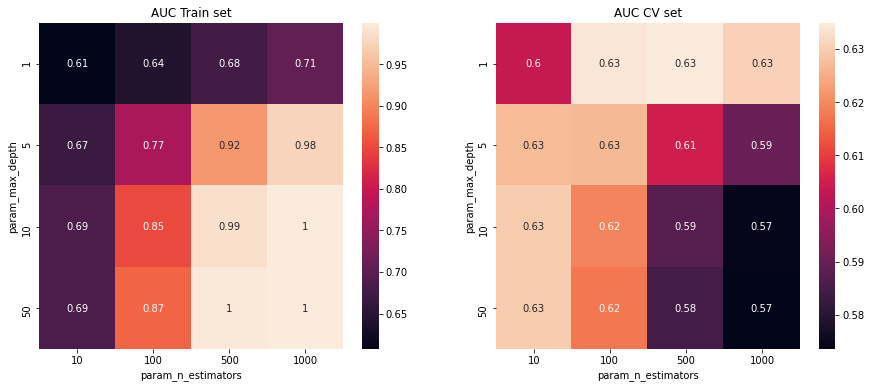

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,2,figsize=(15,6))
sns.heatmap(results1.mean_train_score,annot=True,ax=ax[0])
sns.heatmap(results1.mean_test_score,annot=True,ax=ax[1])

ax[0].set_title('AUC Train set')
ax[1].set_title('AUC CV set')

In [172]:
print(clf1.best_estimator_)
print(clf1.score(X_train_data1,Y_train))
print(clf1.score(X_test_data1,Y_test))

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
0.6661066527584023
0.6322324559601139


In [173]:
best_max_depth=1
best_n_estimator=500

In [175]:
gbdt=lgb.LGBMClassifier(boosting_type='gbdt',class_weight='balanced',max_depth=best_max_depth,n_estimators=best_n_estimator)
gbdt.fit(X_train_data1,Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [176]:
Y_predict_train=gbdt.predict_proba(X_train_data1)[:,1]
Y_predict_test=gbdt.predict_proba(X_test_data1)[:,1]

In [177]:
print(Y_predict_train.shape,Y_predict_test.shape)

(73196,) (36052,)


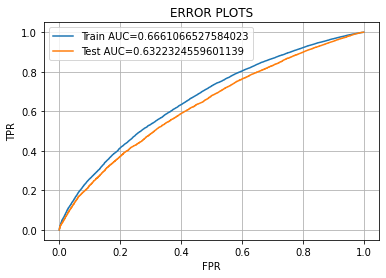

In [178]:
from sklearn.metrics import roc_curve,auc

train_fpr1,train_tpr1,tr_thresholds1=roc_curve(Y_train,Y_predict_train)
test_fpr1,test_tpr1,te_thresholds1=roc_curve(Y_test,Y_predict_test)
plt.plot(train_fpr1,train_tpr1,label='Train AUC='+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1, test_tpr1,label='Test AUC='+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()

In [179]:
def find_best_threshold(threshold,fpr,tpr,set_no):
    t=threshold[np.argmax(tpr*(1-fpr))]
    print("The maximum value of tpr*(1-fpr)",max(tpr*(1-fpr)),"for threshold",np.round(t,3),"for set",set_no)
    return t

def predict_with_best_t(proba,threshold):
    predictions=[]
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [180]:
from sklearn.metrics import confusion_matrix

best_t1=find_best_threshold(tr_thresholds1,train_fpr1,train_tpr1,1)

print("Train confusion matrix")
print(confusion_matrix(Y_train,predict_with_best_t(Y_predict_train,best_t1)))

print("Test confusion matrix")
predict1=predict_with_best_t(Y_predict_test,best_t1)
print(confusion_matrix(Y_test,predict_with_best_t(Y_predict_test,best_t1)))

The maximum value of tpr*(1-fpr) 0.38153501956459435 for threshold 0.492 for set 1
Train confusion matrix
[[ 6939  4144]
 [24262 37851]]
Test confusion matrix
[[ 4873   586]
 [23344  7249]]


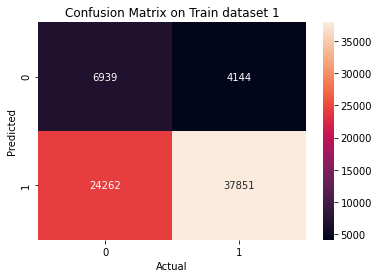

In [181]:
ax=sns.heatmap(np.array(confusion_matrix(Y_train,predict_with_best_t(Y_predict_train,best_t1))),annot=True,fmt="")
ax.set(xlabel='Actual',ylabel='Predicted')
ax.set_title('Confusion Matrix on Train dataset 1')
plt.show()

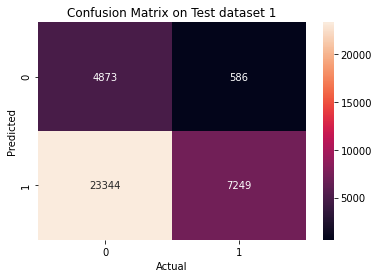

In [182]:
ax=sns.heatmap(np.array(confusion_matrix(Y_test,predict_with_best_t(Y_predict_test,best_t1))),annot=True,fmt="")
ax.set(xlabel='Actual',ylabel='Predicted')
ax.set_title('Confusion Matrix on Test dataset 1')
plt.show()

<h2>Set2</h2>

In [183]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

parameters={'max_depth':[1,5,10,50],'n_estimators':[10,100,500,1000]}

gbdt=lgb.LGBMClassifier(boosting_type='gbdt',class_weight='balanced')
clf2=GridSearchCV(gbdt,parameters,scoring='roc_auc',cv=3,n_jobs=-1,return_train_score=True)
clf2.fit(X_train_data2,Y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50]

In [184]:
results2=pd.DataFrame(clf2.cv_results_).groupby(['param_max_depth','param_n_estimators']).max().unstack()[['mean_train_score','mean_test_score']]
results2

mean_train_score            ... mean_test_score          
param_n_estimators             10        100   ...            500       1000
param_max_depth                                ...                          
1                          0.607427  0.642258  ...        0.639251  0.637228
5                          0.673707  0.841281  ...        0.597617  0.585499
10                         0.686636  0.884902  ...        0.593050  0.582748
50                         0.687195  0.886569  ...        0.594881  0.583548

[4 rows x 8 columns]

Text(0.5, 1.0, 'AUC CV set')

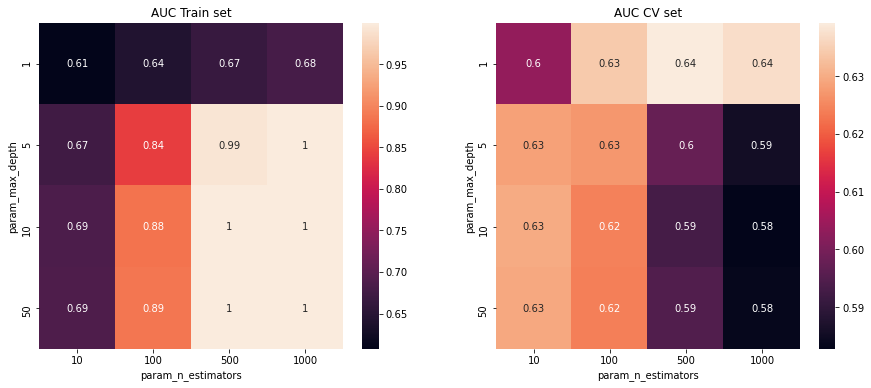

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,2,figsize=(15,6))
sns.heatmap(results2.mean_train_score,annot=True,ax=ax[0])
sns.heatmap(results2.mean_test_score,annot=True,ax=ax[1])

ax[0].set_title('AUC Train set')
ax[1].set_title('AUC CV set')

In [187]:
print(clf2.best_estimator_)
print(clf2.score(X_train_data2,Y_train))
print(clf2.score(X_test_data2,Y_test))

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
0.6583166097199656
0.6368524307879038


In [188]:
best_max_depth=1
best_n_estimator=500

In [189]:
gbdt=lgb.LGBMClassifier(boosting_type='gbdt',class_weight='balanced',max_depth=best_max_depth,n_estimators=best_n_estimator)
gbdt.fit(X_train_data2,Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [190]:
Y_predict_train=gbdt.predict_proba(X_train_data2)[:,1]
Y_predict_test=gbdt.predict_proba(X_test_data2)[:,1]

In [191]:
print(Y_predict_train.shape,Y_predict_test.shape)

(73196,) (36052,)


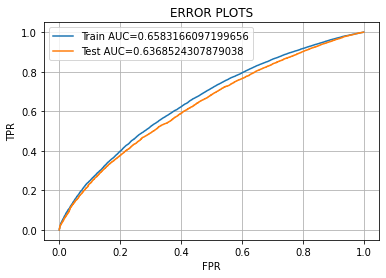

In [192]:
from sklearn.metrics import roc_curve,auc

train_fpr2,train_tpr2,tr_thresholds2=roc_curve(Y_train,Y_predict_train)
test_fpr2,test_tpr2,te_thresholds2=roc_curve(Y_test,Y_predict_test)
plt.plot(train_fpr2,train_tpr2,label='Train AUC='+str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2,test_tpr2,label='Test AUC='+str(auc(test_fpr2,test_tpr2)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()

In [193]:
from sklearn.metrics import confusion_matrix

best_t2=find_best_threshold(tr_thresholds2,train_fpr2,train_tpr2,2)

print("Train confusion matrix")
print(confusion_matrix(Y_train,predict_with_best_t(Y_predict_train,best_t2)))

print("Test confusion matrix")
predict2=predict_with_best_t(Y_predict_test,best_t2)
print(confusion_matrix(Y_test,predict_with_best_t(Y_predict_test,best_t2)))

The maximum value of tpr*(1-fpr) 0.3750963916781681 for threshold 0.495 for set 2
Train confusion matrix
[[ 6951  4132]
 [24965 37148]]
Test confusion matrix
[[ 5044   415]
 [24818  5775]]


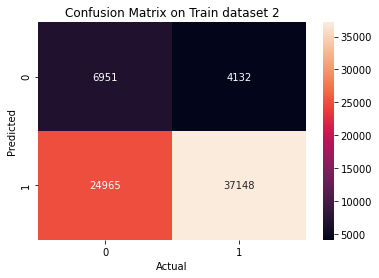

In [194]:
ax=sns.heatmap(np.array(confusion_matrix(Y_train,predict_with_best_t(Y_predict_train,best_t2))),annot=True,fmt="")
ax.set(xlabel='Actual',ylabel='Predicted')
ax.set_title('Confusion Matrix on Train dataset 2')
plt.show()

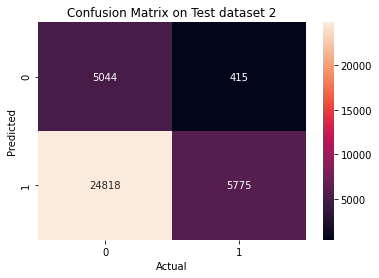

In [195]:
ax=sns.heatmap(np.array(confusion_matrix(Y_test,predict_with_best_t(Y_predict_test,best_t2))),annot=True,fmt="")
ax.set(xlabel='Actual',ylabel='Predicted')
ax.set_title('Confusion Matrix on Test dataset 2')
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [197]:
from prettytable import PrettyTable

table=PrettyTable()
table.field_names=['Vectorizer','Model','Best Max Depth','Best No. of Estimator','AUC']

table.add_row(['TFIDF','GBDT','1','500','0.632'])
table.add_row(['TFIDF W2V','GBDT','1','500','0.636'])

print(table)

+------------+-------+----------------+-----------------------+-------+
| Vectorizer | Model | Best Max Depth | Best No. of Estimator |  AUC  |
+------------+-------+----------------+-----------------------+-------+
|   TFIDF    |  GBDT |       1        |          500          | 0.632 |
| TFIDF W2V  |  GBDT |       1        |          500          | 0.636 |
+------------+-------+----------------+-----------------------+-------+
